In [180]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc

# 한글 폰트 설정 (Windows: 'Malgun Gothic')
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows 기본 한글 폰트
font_name = font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font_name)

# 마이너스 깨지는 것 방지
matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [181]:
# 1. 데이터 불러오기
file_path = r'C:\Python\Water_Flow_Rate.xlsx'

# 엑셀 파일 읽기 (openpyxl 엔진 사용)
df = pd.read_excel(file_path, engine='openpyxl')

# 데이터 확인
print(df)

                 연월일시  가압장유출유량적산차  배수지유입유량적산차
0    2024/12/14 01:00           0           0
1    2024/12/14 02:00           0           0
2    2024/12/14 03:00           0           0
3    2024/12/14 04:00           0           0
4    2024/12/14 05:00           0           0
..                ...         ...         ...
427  2024/12/31 20:00           0          71
428  2024/12/31 21:00         275         354
429  2024/12/31 22:00         332         420
430  2024/12/31 23:00           0          74
431  2024/12/31 24:00           0          13

[432 rows x 3 columns]


In [200]:
# 2. 데이터 전처리
# 실제 컬럼명 사용: '연월일시', '가압장유출유량적산차(㎥)', '배수지유입유량적산차(㎥)'

# 엑셀파일 컬럼 설정
df['날짜'] = df['연월일시']
df['가압장_적산차'] = df['가압장유출유량적산차']
df['배수지_적산차'] = df['배수지유입유량적산차']

# 배수지유입유량-가압장유출유량 계산 (배수지 적산차 - 가압장 적산차)
df['적산차'] = df['배수지_적산차'] - df['가압장_적산차']

# 이상상태 라벨링 (가압하지 않는 시간대에 배수지 유량이 찍히는 경우, 적산차 계산)
condition = (df['가압장_적산차'] == 0) & (df['배수지_적산차'] > 0)
df['이상상태'] = np.where(condition, 1, 0)
df['적산차_이상'] = np.where(df['이상상태'] == 1, df['적산차'], np.nan)

# 유수율 계산 (이상상태일때 필터링)
df['유수율'] = np.where((df['이상상태'] == 0), 
                        (df['배수지_적산차'] / df['가압장_적산차']) * 100, 
                        np.nan)  # 가압장_적산차와 배수지_적산차 모두 0일 경우 NaN 처리

# 유수율 계산 오류 처리 (가압장_적산차가 0, 배수지_적산차가 0이 아닐때 오류로 처리) = 앞의 이상상태 변수와 동일
df['유수율계산오류'] = np.where((df['가압장_적산차'] == 0) & (df['배수지_적산차'] != 0), 1, 0)

# 결측치 처리: 양옆의 값으로 결측치 채우기
df['가압장_적산차'] = df['가압장_적산차'].ffill().bfill()
df['배수지_적산차'] = df['배수지_적산차'].ffill().bfill()

# 이상치 처리: 이상상태일 경우 배수지_적산차를 가압장_적산차와 동일하게 맞추기
df.loc[df['이상상태'] == 1, '배수지_적산차'] = df['가압장_적산차']

# 유수율 데이터의 출력 포맷을 %로 지정 (소수점 1자리로 제한)
df['유수율'] = df['유수율'].apply(lambda x: f"{x:.1f}%" if pd.notna(x) else x)

# 전처리 결과 확인
print(df[['날짜', '가압장_적산차', '배수지_적산차', '적산차', '적산차_이상', '유수율', '유수율계산오류', '이상상태']])

                   날짜  가압장_적산차  배수지_적산차  적산차  적산차_이상     유수율  유수율계산오류  이상상태
0    2024/12/14 01:00        0        0    0     NaN     NaN        0     0
1    2024/12/14 02:00        0        0    0     NaN     NaN        0     0
2    2024/12/14 03:00        0        0    0     NaN     NaN        0     0
3    2024/12/14 04:00        0        0    0     NaN     NaN        0     0
4    2024/12/14 05:00        0        0    0     NaN     NaN        0     0
..                ...      ...      ...  ...     ...     ...      ...   ...
427  2024/12/31 20:00        0        0   71    71.0     NaN        1     1
428  2024/12/31 21:00      275      354   79     NaN  128.7%        0     0
429  2024/12/31 22:00      332      420   88     NaN  126.5%        0     0
430  2024/12/31 23:00        0        0   74    74.0     NaN        1     1
431  2024/12/31 24:00        0        0   13    13.0     NaN        1     1

[432 rows x 8 columns]


In [203]:
# 2.1 모델학습을 위해 유수율에서 '%' 기호를 제거하고 실수(float)로 변환
df['유수율'] = df['유수율'].astype(str).str.replace('%', '').astype(float)

# 결과 확인
print(df[['날짜', '유수율']])

                   날짜    유수율
0    2024/12/14 01:00    NaN
1    2024/12/14 02:00    NaN
2    2024/12/14 03:00    NaN
3    2024/12/14 04:00    NaN
4    2024/12/14 05:00    NaN
..                ...    ...
427  2024/12/31 20:00    NaN
428  2024/12/31 21:00  128.7
429  2024/12/31 22:00  126.5
430  2024/12/31 23:00    NaN
431  2024/12/31 24:00    NaN

[432 rows x 2 columns]


In [211]:
# 3. 학습용 데이터셋 준비
X = df[['가압장_적산차', '배수지_적산차', '적산차', '적산차_이상', '유수율']]
y = df['이상상태']

# 학습 데이터와 테스트 데이터 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=432)


In [212]:
# 4. RandomForest 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=432)
rf_model.fit(X_train, y_train)

# RandomForest 예측
rf_preds = rf_model.predict(X_test)

# RandomForest 결과 출력
print("\n===== RandomForest 결과 =====")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))


===== RandomForest 결과 =====
Accuracy: 1.0
Confusion Matrix:
 [[29  0]
 [ 0 58]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        58

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87



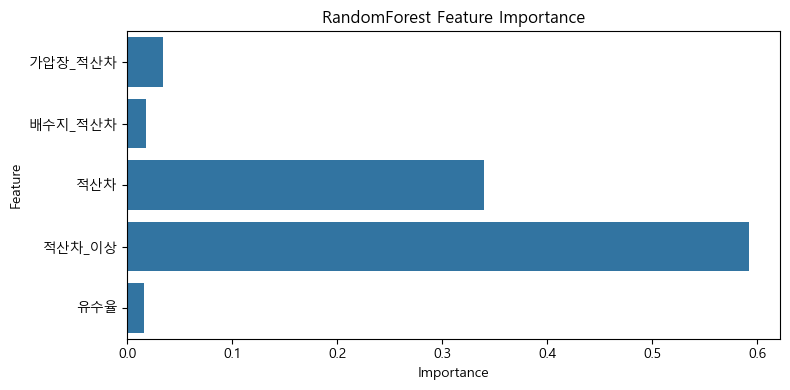

In [ ]:
# 5. Feature Importance 시각화 (RandomForest 기준)
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_names)
plt.title('RandomForest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#분석결과
#1. 가압장_적산차, 배수지_적산차, 유수율은 중요도가 낮으며,
#2. 적산차가 발생하는 시점 중 적산차_이상이 발생했을 떄 이상상태에 도달한 것으로 판단할 수 있음.


In [214]:
# 6. XGBoost 모델 학습
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# XGBoost 예측
xgb_preds = xgb_model.predict(X_test)

# XGBoost 결과 출력
print("\n===== XGBoost 결과 =====")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))


===== XGBoost 결과 =====
Accuracy: 1.0
Confusion Matrix:
 [[29  0]
 [ 0 58]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        58

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87



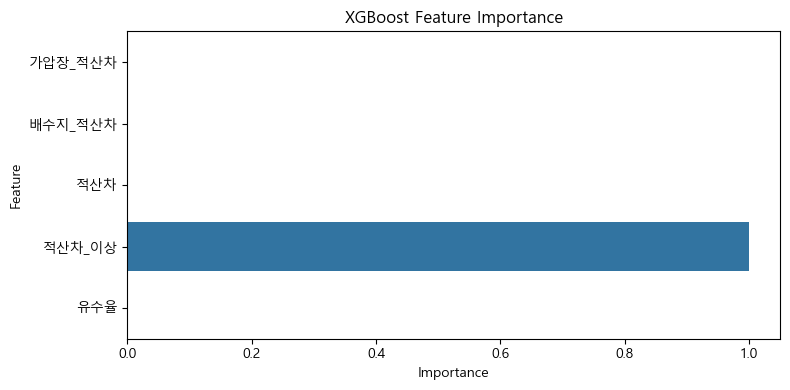

In [ ]:
# 7. Feature Importance 시각화 (XGBoost 기준)
xgb_importances = xgb_model.feature_importances_

plt.figure(figsize=(8, 4))
sns.barplot(x=xgb_importances, y=feature_names)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#분석결과
# 적산차_이상이 발생할 때, 100% 이상상태임을 알 수 있음

In [127]:
# 8. RandomForest + XGBoost 앙상블 (Voting)
ensemble_model = VotingClassifier(
    estimators=[('RandomForest', rf_model), ('XGBoost', xgb_model)],
    voting='soft'
)

# 앙상블 모델 학습
ensemble_model.fit(X_train, y_train)

# 앙상블 모델 예측
ensemble_preds = ensemble_model.predict(X_test)

# 앙상블 결과 출력
print("\n===== 앙상블(VotingClassifier) 결과 =====")
print("Accuracy:", accuracy_score(y_test, ensemble_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, ensemble_preds))
print("Classification Report:\n", classification_report(y_test, ensemble_preds))


===== 앙상블(VotingClassifier) 결과 =====
Accuracy: 1.0
Confusion Matrix:
 [[29  0]
 [ 0 58]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        58

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87



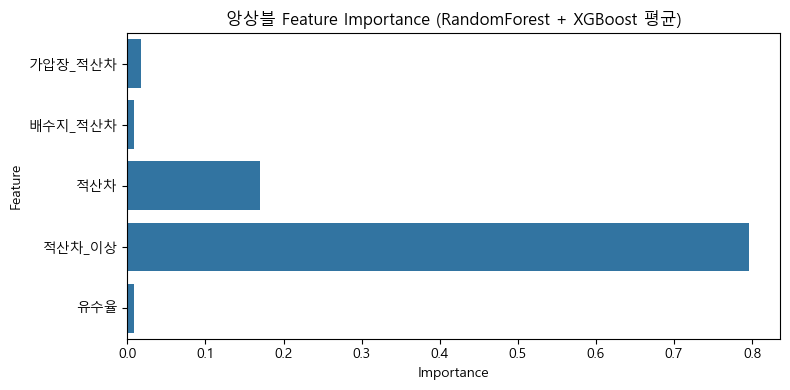

In [220]:
# 9. 앙상블 Feature Importance 시각화 (Voting)
# 앙상블 모델은 평균적인 중요도를 보기 때문에 개별 모델들의 feature importance를 평균화하여 시각화
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

# 평균 중요도 계산
average_importances = (rf_importances + xgb_importances) / 2

plt.figure(figsize=(8, 4))
sns.barplot(x=average_importances, y=feature_names)
plt.title('앙상블 Feature Importance (RandomForest + XGBoost 평균)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#분석결과
# 두기법을 합하여 분석한 것으로, xgboost의 정확도가 높다고 판단